# Callin Switzer
Read in all csv files from individual trials, and 
combine into a single long dataset

Updated 4 Dec, 2017


In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import os
import pandas as pd
import time
import re
from datetime import datetime
import sys
import csv
import seaborn as sns

print(sys.version)

3.6.1 |Anaconda custom (64-bit)| (default, May 11 2017, 13:04:09) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]


In [2]:
# define directories
baseDir = os.getcwd()
dataDir = '/Users/cswitzer/Dropbox/SonicationBehavior/SonBehData/SonicationBehaviorTrials_NoImages/'


In [3]:
os.chdir(dataDir)

In [4]:
fldrs = [f for f in os.listdir(".") if not f.startswith('.')]
len(fldrs) # should be 232

232

In [5]:
fldrs.sort(key=lambda x: os.path.getmtime(x)) # sort by time created

In [6]:
# write list of all trials
with open("/Users/cswitzer/Dropbox/SonicationBehavior/SonBehData/RawDataFilenames.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(np.transpose(np.array([fldrs])))

In [7]:
os.chdir(dataDir)

In [8]:
# for each folder, open it, and read the ampFreq.txt file

folders = fldrs

NoFlightFolder = "/Users/cswitzer/Dropbox/SonicationBehavior/SonBehData/SonicationBehaviorData_FlightsRemoved/"

probs = 0
for ii in range(len(folders)):

    # read contents of each folder
    fcontents = [f for f in os.listdir(folders[ii]) if not f.startswith('.')]

    # get ampFreq file(s). there should be one per folder
    ampFreqFile = [x for x in fcontents if 'ampFreq.txt' in x]

    if len(ampFreqFile) > 1: 
        print("PROBLEM " + str(ii))


    # read ampFreq file
    tmpDF = pd.read_table(os.path.join(folders[ii], ampFreqFile[0]), header = None, sep = ',')

    # add folder name to data frame
    tmpDF[7] = folders[ii]

    # add frequency information
    folderInFolder = [x for x in fcontents if not 'ampFreq.txt' in x]

    if len(folderInFolder) > 1: 
        print("PROBLEM")
        probs += 1

    # list files in inner folder
    accRecFiles = [x for x in os.listdir(os.path.join(folders[ii], folderInFolder[0])) if not x.startswith('.')]
    accRecFiles.sort()

    tmpDF[8] = accRecFiles

    # remove wingbeats
    tmpDF2 = tmpDF.loc[(tmpDF[0] > 220) & (tmpDF[0] < 450)]

    # renumber index
    tmpDF2.index = (np.arange(1, tmpDF2.shape[0] + 1))

    # write to .csv
    tmpDF2.to_csv(NoFlightFolder + folders[ii] + '.csv', 
                 header = False, index = True)
    
    if np.mod(ii, 10) == 0:
        print(ii)
    
print(str(probs) + " problems")

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
0 problems


In [9]:
## combine csv's all into a single file
csvDir = NoFlightFolder

csvFiles = [f for f in os.listdir(csvDir) if f.endswith('.csv')]

np_array_list = []
for file_ in csvFiles:
    df = pd.read_csv(os.path.join(csvDir, file_),index_col=None, header=None)
    np_array_list.append(df.as_matrix())

comb_np_array = np.vstack(np_array_list)
big_frame = pd.DataFrame(comb_np_array)

big_frame.columns = ['index', 'freq', 'amp', 'datetime', 'rewNum', 'rewTF', 'lowRewAmp', 'highrewAmp', 'BeeNumCol', 'accFile']

big_frame.head()

,index,freq,amp,datetime,rewNum,rewTF,lowRewAmp,highrewAmp,BeeNumCol,accFile
0,1,340,0.69799,2016_12_11__14_51_35_856,1,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_35_856_220_450_test.txt
1,2,290,0.31249,2016_12_11__14_51_37_400,2,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_37_400_220_450_test.txt
2,3,310,0.49291,2016_12_11__14_51_38_788,3,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_38_788_220_450_test.txt
3,4,310,0.55911,2016_12_11__14_51_39_641,4,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_39_641_220_450_test.txt
4,5,350,0.30275,2016_12_11__14_51_41_043,5,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_41_043_220_450_test.txt


In [10]:
big_frame["freq"].shape

(26552,)

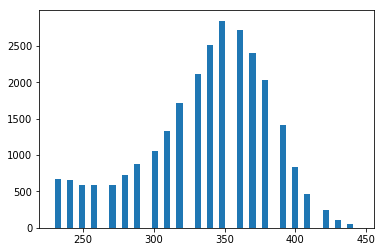

In [11]:
# plot histogram of frequencies
vls = [int(big_frame["freq"][ii]) for ii in range(len(big_frame))]
plt.hist(vls, bins = 50)
plt.show()

In [12]:
# check to see if datetime and accFile agree
eqs = [big_frame['datetime'][ii][1:25] == big_frame['accFile'][ii][0:24] for ii in range(len(big_frame['datetime']))]

In [13]:
np.sum(np.invert(eqs)) # should be zero if all of them match

0

In [14]:
# find the one that doesn't match
big_frame.loc[np.invert(eqs)] # now they all match

,index,freq,amp,datetime,rewNum,rewTF,lowRewAmp,highrewAmp,BeeNumCol,accFile


### make a new column for bee color, hive, reward frequency, date, and treatment (initial, high, low)



In [15]:
str2 = [big_frame['BeeNumCol'][ii].split("Bee")[1] for ii in range(len(big_frame['BeeNumCol']))]

In [16]:
beeColNum = [str2[ii].split(r'_')[0] for ii in range(len(str2))]

In [17]:
# definition for extracting trial number
def extractNum(string):
    try: 
        aa =  str(int(filter(str.isdigit, string)))
    except:
        aa = "1"
    return(aa)
    

In [18]:
# get trial number
trialNum = [extractNum(strg) for strg in beeColNum]

In [19]:
# function to get only characters
def extractChar(string):
    return(" ".join(re.findall("[a-zA-Z]+", string)))

In [20]:
# get just bee color
beeCol = [extractChar(strg) for strg in beeColNum]

In [21]:
# get datetime
dateTime = [datetime.strptime(dt1, ' %Y_%m_%d__%H_%M_%S_%f') for dt1 in big_frame['datetime']]

In [22]:
# string format time
dateTime_format = [datetime.strftime(datetime_object, "%Y-%m-%d %H:%M:%S.%f") for datetime_object in dateTime]

In [23]:
# get reward frequencies
s1 = big_frame['accFile'][0]

In [24]:
rewFrqs = [s1.split("_")[8:10] for s1 in big_frame['accFile']]

In [25]:
rewDF = pd.DataFrame(rewFrqs, columns = ['lowFrq', 'highFrq'])

In [26]:
# add to big data frame
big_frame['trialNum'] = trialNum
big_frame['beeCol'] = beeCol
big_frame['datetime_str'] = dateTime_format

In [27]:
big_frame2 = pd.concat([big_frame, rewDF], axis  = 1)
big_frame2.head()

,index,freq,amp,datetime,rewNum,rewTF,lowRewAmp,highrewAmp,BeeNumCol,accFile,trialNum,beeCol,datetime_str,lowFrq,highFrq
0,1,340,0.69799,2016_12_11__14_51_35_856,1,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_35_856_220_450_test.txt,1,silver,2016-12-11 14:51:35.856000,220,450
1,2,290,0.31249,2016_12_11__14_51_37_400,2,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_37_400_220_450_test.txt,1,silver,2016-12-11 14:51:37.400000,220,450
2,3,310,0.49291,2016_12_11__14_51_38_788,3,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_38_788_220_450_test.txt,1,silver,2016-12-11 14:51:38.788000,220,450
3,4,310,0.55911,2016_12_11__14_51_39_641,4,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_39_641_220_450_test.txt,1,silver,2016-12-11 14:51:39.641000,220,450
4,5,350,0.30275,2016_12_11__14_51_41_043,5,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_41_043_220_450_test.txt,1,silver,2016-12-11 14:51:41.043000,220,450


In [28]:
big_frame2.to_csv('/Users/cswitzer/Dropbox/SonicationBehavior/SonBehData/CombinedBeeTrials_noWingbeats.csv', header = True, index = False)

In [29]:
# print system info
import IPython
print(IPython.sys_info())

{'commit_hash': '5a894b9',
 'commit_source': 'installation',
 'default_encoding': 'UTF-8',
 'ipython_path': '/Users/cswitzer/anaconda/envs/python3/lib/python3.6/site-packages/IPython',
 'ipython_version': '5.3.0',
 'os_name': 'posix',
 'platform': 'Darwin-17.2.0-x86_64-i386-64bit',
 'sys_executable': '/Users/cswitzer/anaconda/envs/python3/bin/python',
 'sys_platform': 'darwin',
 'sys_version': '3.6.1 |Anaconda custom (64-bit)| (default, May 11 2017, '
                '13:04:09) \n'
                '[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]'}


In [30]:
# show installed packages and versions
!pip freeze 

alabaster==0.7.10
anaconda-client==1.6.3
anaconda-navigator==1.6.2
anaconda-project==0.6.0
appnope==0.1.0
appscript==1.0.1
asn1crypto==0.22.0
astroid==1.4.9
astropy==1.3.2
Babel==2.4.0
backports.functools-lru-cache==1.4
backports.shutil-get-terminal-size==1.0.0
beautifulsoup4==4.6.0
bitarray==0.8.1
blaze==0.10.1
bleach==1.5.0
bokeh==0.12.5
boto==2.46.1
Bottleneck==1.2.1
cffi==1.10.0
chardet==3.0.3
click==6.7
cloudpickle==0.2.2
clyent==1.2.2
colorama==0.3.9
conda==4.3.30
contextlib2==0.5.5
cryptography==1.8.1
cycler==0.10.0
Cython==0.25.2
cytoolz==0.8.2
dask==0.14.3
datashape==0.5.4
decorator==4.0.11
distributed==1.16.3
docutils==0.13.1
entrypoints==0.2.2
et-xmlfile==1.0.1
fastcache==1.0.2
Flask==0.12.2
Flask-Cors==3.0.2
gevent==1.2.1
greenlet==0.4.12
h5py==2.7.1
HeapDict==1.0.0
html5lib==0.999
idna==2.5
imagesize==0.7.1
ipykernel==4.6.1
ipython==5.3.0
ipython-genutils==0.2.0
ipywidgets==6.0.0
isort==4.2.5
itsdangerous==0.24
jdcal==1.3
jedi==0.10.2
Jinja2==2.9.6
jsonschema==2.6.0
jupyte

In [31]:
# convert to html, so ppl don't have to run python to see code
os.chdir(baseDir)
!jupyter nbconvert --to html 001_CombineTrialsIntoLongCSV

[NbConvertApp] Converting notebook 001_CombineTrialsIntoLongCSV.ipynb to html
[NbConvertApp] Writing 303003 bytes to 001_CombineTrialsIntoLongCSV.html
